# PNUEMONIA Classifier

Dataset : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

![](Images/image_1.png)

The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse interstitial pattern in both lungs.

## Content
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
import random
import glob
import cv2

In [2]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, Lambda, Activation
from tensorflow.keras.optimizers import Adam

In [3]:
np.random.seed(2)
tf.random.set_seed(2)

In [4]:
def dataset_details(data_dir):
    for dir in ['train', 'test', 'val']:
        curr_dir = os.path.join(data_dir, dir)
        sub_dir = [ subfolder for subfolder in os.listdir(curr_dir) if os.path.isdir(os.path.join(curr_dir, subfolder))]
        for sub in sub_dir:
            inner_dir = os.path.join(curr_dir,sub)
            total = len([name for name in os.listdir(inner_dir) if os.path.isfile(os.path.join(inner_dir, name))])
            print("For {} - {}: {}".format(dir,sub,total))

In [5]:
def preprocess(img):
    img = cv2.resize(img , (200,200))
    img = img / 255.0
    return img

In [6]:
def display_sample_data(data_dir, total_data):
    plt.figure(figsize = (20,20))
    files = glob.glob(data_dir+ '/*.jpeg')
    for i in range(1,4):
        x = random.randint(0, total_data)
        image = cv2.imread(files[x])
        print(image.shape)
        image = preprocess(image)
        print(image.shape)
        plt.subplot(1,3,i)
        plt.imshow(image, cmap = 'gray')

## Data Directory Structure

![](Images/image_2.png)

## Normal Chest X-Ray vs Pneumonia Cest X-Ray

#### Normal
![](Images/normal.png)

#### Pneumonia
![](Images/pneumonia.png)

In [7]:
data_dir = '.\\chest_xray\\chest_xray'
dataset_details(data_dir)

For train - NORMAL: 1341
For train - PNEUMONIA: 3875
For test - NORMAL: 234
For test - PNEUMONIA: 390
For val - NORMAL: 9
For val - PNEUMONIA: 9


In [8]:
data_dir = '.\\chest_xray\\chest_xray\\train\\NORMAL'

(1604, 1580, 3)
(200, 200, 3)
(1299, 1530, 3)
(200, 200, 3)
(1418, 1808, 3)
(200, 200, 3)


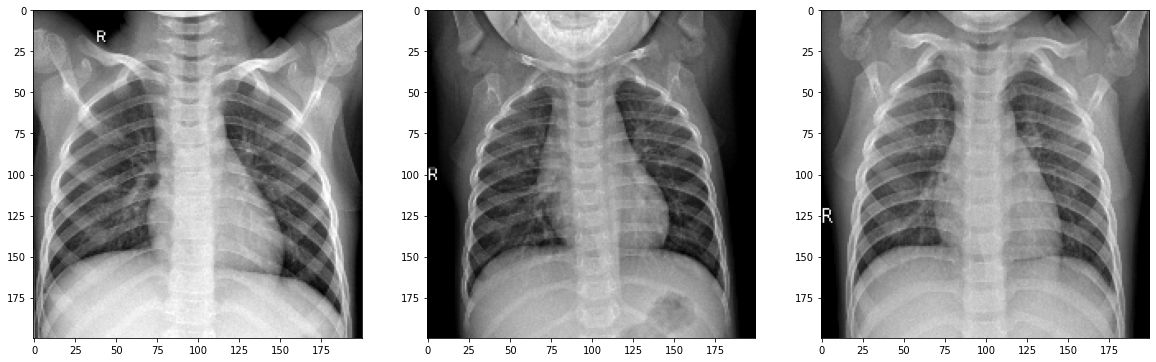

In [9]:
display_sample_data(data_dir,1342)

(672, 952, 3)
(200, 200, 3)
(1137, 1480, 3)
(200, 200, 3)
(618, 759, 3)
(200, 200, 3)


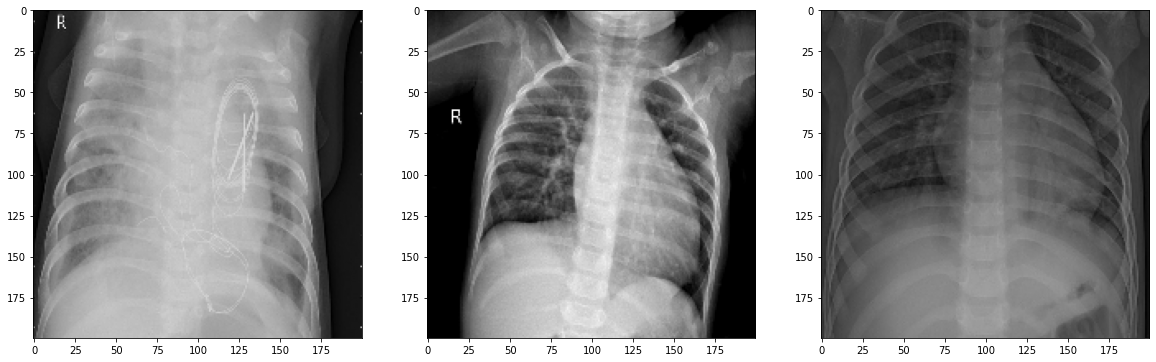

In [10]:
data_dir = '.\\chest_xray\\chest_xray\\train\\PNEUMONIA'
display_sample_data(data_dir,3876)

In [11]:
data_dir = '.\\chest_xray\\chest_xray'
train_dir = os.path.join(data_dir,'train')
test_dir = os.path.join(data_dir,'test')
val_dir = os.path.join(data_dir,'val')


In [12]:
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(train_dir, class_mode = 'binary', batch_size = 64)
test_gen = datagen.flow_from_directory(test_dir, class_mode = 'binary', batch_size = 1)
val_gen = datagen.flow_from_directory(val_dir, class_mode = 'binary', batch_size = 1)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [13]:
from tensorflow.keras import initializers
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [20]:
def classification_model():

    original_dim = (None, None, 3)
    target_size = (300, 300)
    input = tf.keras.layers.Input(original_dim)
    x = Lambda(lambda image: tf.image.resize(image, target_size))(input)
    x = Conv2D(32, (5,5) , input_shape = (300,300,3), activation = 'relu', strides = (2,2))(x)
    x = MaxPool2D(pool_size=(2,2), strides = (1,1))(x)
    #x = Dropout(0.5)(x)
    x = Conv2D(48,(5,5), activation = 'relu', strides = (2,2))(x)
    x = Conv2D(48,(5,5), activation = 'relu', strides = (2,2))(x)
    x = MaxPool2D(pool_size=(2,2), strides = (1,1))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(64,(5,5), activation = 'relu', strides = (2,2))(x)
    x = Conv2D(64,(5,5), activation = 'relu', strides = (2,2))(x)
    x = MaxPool2D(pool_size=(2,2), strides = (1,1))(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    #x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,trainable=True)(x)
    #x = Dropout(0.5)(x)
    #x = Dense(100, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)

    model = Model(inputs = input, outputs = x)

    optimizer = Adam(lr = 1e-5)
    model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics = ['accuracy'])
    
    return model

In [21]:
model = classification_model()
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 148, 148, 32)      2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 147, 147, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 48)        38448     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 48)        57648     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 33, 33, 48)        0   

In [22]:
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)

In [23]:
def plot_loss(loss, val_loss):
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training_data','validation_data'])
    plt.title('loss')
    plt.xlabel('Epoch')

In [24]:
history = model.fit_generator(train_gen, steps_per_epoch = 81, validation_data = val_gen, validation_steps = 16, epochs = 15, verbose = True, shuffle = True, callbacks=[checkpoint])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 81 steps, validate for 16 steps
Epoch 1/15
81/81 [==============================] - 42s 513ms/step - loss: 0.5787 - accuracy: 0.7413 - val_loss: 0.7199 - val_accuracy: 0.5000
Epoch 2/15
81/81 [==============================] - 41s 505ms/step - loss: 0.5571 - accuracy: 0.7432 - val_loss: 0.7024 - val_accuracy: 0.5000
Epoch 3/15
81/81 [==============================] - 40s 495ms/step - loss: 0.5272 - accuracy: 0.7475 - val_loss: 0.7032 - val_accuracy: 0.5000
Epoch 4/15
81/81 [==============================] - 41s 504ms/step - loss: 0.4796 - accuracy: 0.7706 - val_loss: 0.6581 - val_accuracy: 0.6250
Epoch 5/15
81/81 [==============================] - 41s 509ms/step - loss: 0.4219 - accuracy: 0.8071 - val_loss: 0.6148 - val_accuracy: 0.6250
Epoch 6/15
81/81 [==============================] - 41s 501ms/step - loss: 0.3592 - accuracy: 0.8414 - val_loss: 0.5428 - val_accuracy: 0.7500
Epoch 7/15
81/81 [==============================] 

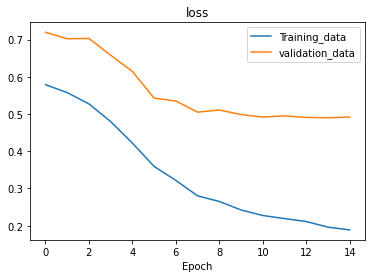

In [25]:

plot_loss(history.history['loss'], history.history['val_loss'])

## Score on Test Data

In [26]:
score = model.evaluate_generator(test_gen, steps=64)
print("Accuracy :{}%".format(score[1]))
print("Loss :{}%".format(score[0]))

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
[0.30825819227902684, 0.90625]


In [27]:
test_dir = os.path.join(data_dir,'test')
test_data = []
test_labels = []
target_size = (300, 300)

for subdir in ['NORMAL', 'PNEUMONIA']:
        for img in (os.listdir(os.path.join(test_dir ,subdir))):
            img = cv2.imread(os.path.join(test_dir ,subdir,img))
            img = cv2.resize(img, target_size)
            img = img.astype('float32') / 255
            label = 0 if subdir =='NORMAL' else 1
            test_data.append(img)
            test_labels.append(label)
        
test_data = np.array(test_data)
test_labels = np.array(test_labels)

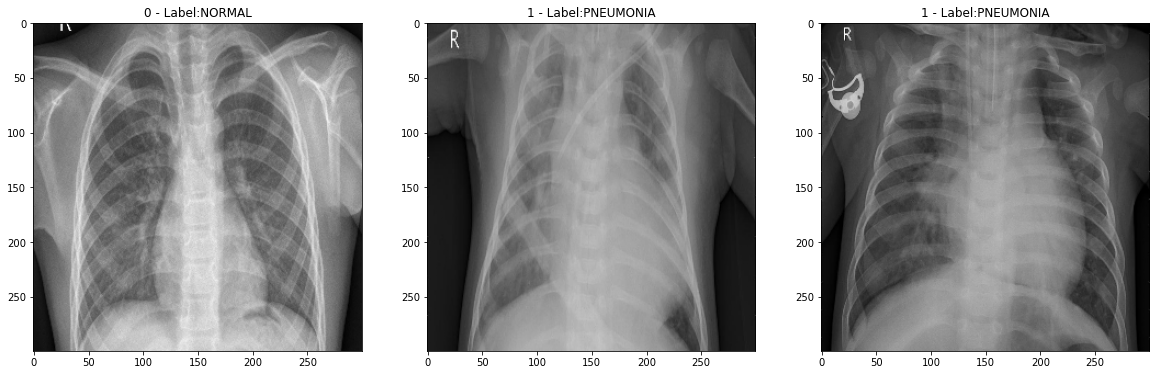

In [28]:
plt.figure(figsize = (20,20))
for i in range(1,4):
    x = random.randint(0, len(test_data))
    image = test_data[x]
    plt.subplot(1,3,i)
    plt.imshow(image, cmap = 'gray')
    label = 'NORMAL' if test_labels[x] == 0 else 'PNEUMONIA'
    title =  '{} - Label:{}'.format(test_labels[x] , label)
    plt.title(title)

## Confusion Matrix to study different scores

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('--------CONFUSION MATRIX --------')
print(cm)

print('\n--------TEST METRICS --------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\n--------TRAIN METRIC --------')
print('Train accuracy: {}'.format(np.round((history.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[205  29]
 [ 64 326]]

TEST METRICS ----------------------
Accuracy: 85.09615384615384%
Precision: 91.83098591549296%
Recall: 83.58974358974359%
F1-score: 87.51677852348993

TRAIN METRIC ----------------------
Train acc: 92.78
